In [146]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import math
from time import sleep


NbSample = 5

def GetLine():

    ser.write("1")
    i = 0
    while (i<1):        
        i=i+1 
        data = ser.readline().strip()
    return data

def sendData(kik):

    ser.write("0")
    ser.write(kik.encode())
 

In [174]:
try:
    ser = serial.Serial('/dev/ttyACM2', 115200)
except serial.SerialException:
    ser = serial.Serial('/dev/ttyACM5', 115200)
print(ser.name) 

/dev/ttyACM2


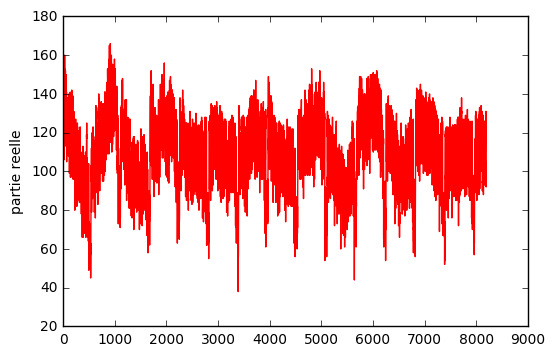

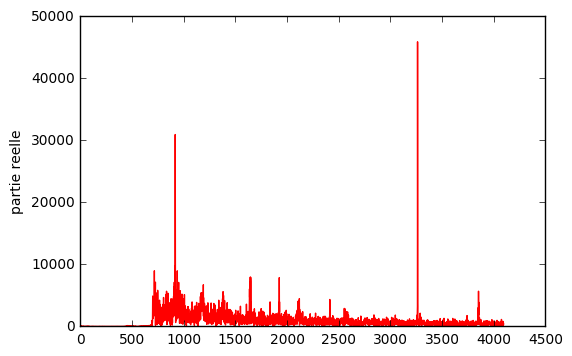

In [184]:
rawData = GetLine()
signal = np.asarray(rawData.split(" ")[-1].split(";EOF")[0].split(";"),dtype=int) 
FFT = (np.fft.fft(signal))

for i in range(5):
    FFT[i] = 0
    FFT[-i] = 0 

for k in range(NbSample):

    rawData = GetLine()
    signal = np.asarray(rawData.split(" ")[-1].split(";EOF")[0].split(";"),dtype=int) 
    FFT += (np.fft.fft(signal))

    for i in range(5):
        FFT[i] = 0
        FFT[-i] = 0 
    
for i in range(700):
    FFT[i] = FFT[i]/(700-i)
    FFT[-i] = FFT[-i]/(700-i)
    
plt.plot(signal,"r")
plt.ylabel("partie reelle")
plt.show()

#plt.plot(range(128),np.abs(FFT[0:128]))
plt.plot(np.abs(FFT[0:len(FFT)/2]),"r")
plt.ylabel("partie reelle")

plt.show()


In [185]:
SamplingFreq =50500
print(SamplingFreq)
N = len(FFT)
Npt = len(signal)
Freqs = [SamplingFreq * x /N for x in range(N/2)]
t = [ 1.0*x/SamplingFreq for x in range(Npt)]

50500


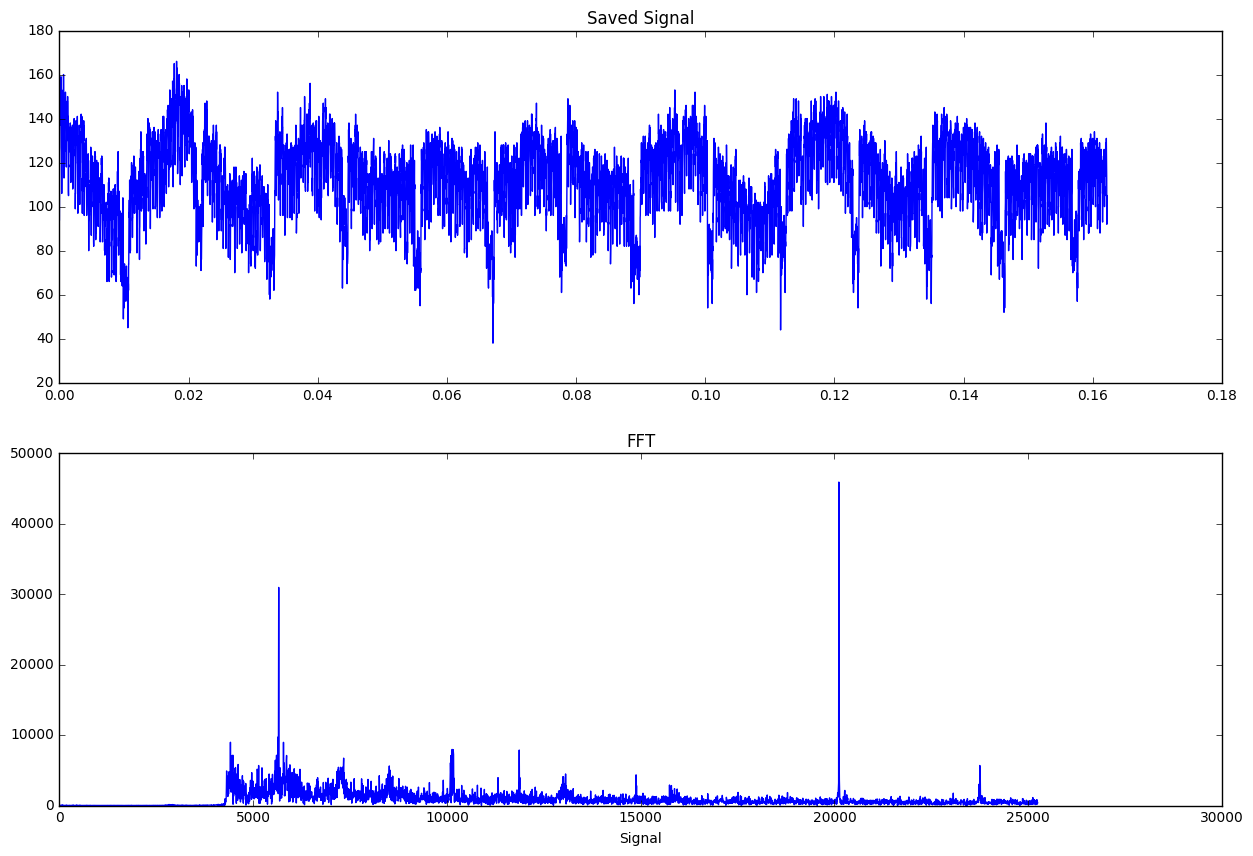

In [186]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,10))
ax1.plot(t,signal)
ax1.set_title('Saved Signal')
plt.xlabel("Time (us)")
ax2.plot(Freqs, np.abs(FFT[0:len(FFT)/2]))
ax2.set_title('FFT')
plt.xlabel("Signal")
plt.show()

## Displays

* 5000 - 21000 -> 15kHz -- 60 pixels -> 250Hz/pixel
* 17500 - 20500 -> 4kHz -- 60 pixels ->  50Hz/pixel

In [187]:
Line = np.zeros(60)
Detail = np.zeros(60)
for k in range(60):
    for l in range(4096):
        if((Freqs[l]> (6000 + k*250)) and (Freqs[l]< (6000 + (k+1)*250))):
            Line[k]+= np.abs(FFT[l])
        if((Freqs[l]> (17500 + k*50)) and (Freqs[l]< (17500 + (k+1)*50))):
            Detail[k]+= np.abs(FFT[l])
            
ScMin =  np.min(np.abs(Line))
Scale =  np.max(np.abs(Line[0:30])-ScMin)
Line = np.asarray(((Line-ScMin)*60/Scale),dtype=int)

for k in range(60):
    if (Line[k] > 60):
        Line[k] = 60
        
DetMin = np.min(np.abs(Detail))
Detail = np.asarray(((Detail-DetMin)*60/Scale),dtype=int)

for k in range(60):
    if (Detail[k] > 60):
        Detail[k] = 60

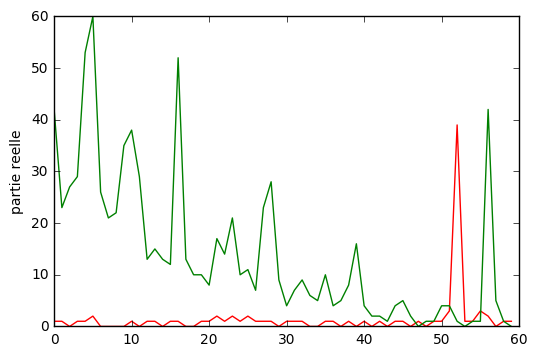

In [188]:
plt.plot(Detail,"r")
plt.plot(Line,"g")
plt.ylabel("partie reelle")

plt.show()

In [189]:
data = ""
for k in range(60):
    data += chr(51+int(Line[k]))
for k in range(60):
    data += chr(51+int(Detail[k]))
data

']JNPhoMHIVYP@B@?g@==;DAH=>:JO<7:<98=78;C7554785344774344]8434434453333434434433445454544434443344343434344343446Z4465344'

In [190]:
sendData(data)

In [191]:
FFT_20k = FFT
Signal_20k = signal
np.savez("18kHzData.npz", FFT_20k=FFT_20k, Signal_20k=Signal_20k)

# Arduino code

<code>

/*
  Blink

*/

// DISPLAY

#include <Adafruit_GFX.h>
#include <Adafruit_SSD1306.h>
#include <adafruit_feather.h>
#include <avr/pgmspace.h>
// Managing arrays


//#include "arduinoFFT.h"
//#include <WProgram.h>
//arduinoFFT FFT = arduinoFFT(); /* Create FFT object */

const uint16_t FFT_N = 256; // set to 256 point fft

//char Received[120];

// OLED
#define OLED_RESET 4
Adafruit_SSD1306 display(OLED_RESET);

bool busy = 0;
unsigned long time1 = 0;
unsigned long time2 = 0;

#define DECIMATION 1
#define BUFFERSIZE 2048

#define   VaLEn 4*BUFFERSIZE
byte val[VaLEn];

uint8_t  calib[32];

uint8_t  GetBack[120];

int j = 0;
int k = 0;
int i = 0;

int led3 = PA15;
int sensorPin1 = PA1;

// the setup function runs once when you press reset or power the board
void setup() {

  pinMode(sensorPin1, INPUT_ANALOG);


  // initialize digital pin 13 as an output.
  pinMode(13, OUTPUT);
  digitalWrite(13, HIGH);





  // Display
  display.begin(SSD1306_SWITCHCAPVCC, 0x3C);  // initialize with the I2C addr 0x3D (for the 128x64)
  display.clearDisplay();
  display.setTextSize(1);
  display.setTextColor(WHITE);
  display.setCursor(0, 0);
  display.println(F("== Test starting == "));
  display.print(F("Free SRAM: ->  "));
  display.println(freeRam ());
  display.display();



  digitalWrite(13, LOW);
  delay(500);
}

// the loop function runs over and over again forever
void loop() {
  if (!busy) {
    while (Serial.available()) {

      int lu = Serial.read();
      display.println(lu);
      display.display();
      if (lu == 49) {
        display.println("Lu == 1");
        display.display();
        transmit();
      }

      if (lu == 48) {
        display.println("Longer");
        display.display();
        busy = 1;
        displayFFT();

      }
    }
  }





}

void displayFFT()
{


  int availableBytes = Serial.available();
  for (int i = 0; i < availableBytes; i++)
  {
    GetBack[i] = Serial.read();
    //display.clearDisplay();
   // display.setCursor(0, 0);
   // display.print(i);display.print(" - ");display.print(GetBack[i]);
   // display.display();
  }

  display.clearDisplay();

  while (i < 4 ) {
    display.drawFastVLine(60 + i, 3, 0 , WHITE);
    display.drawFastVLine(122 + i, 3, 0 , WHITE);
    i++;
  }

  while (i < 120 ) {
    display.drawFastVLine(3+i, 3, GetBack[i]  - 51 , WHITE);
    //display.drawFastVLine(64 + i, 0, GetBack[60+i] , WHITE);
    i++;
  }

display.drawFastVLine(60, 0, 3 , WHITE);
display.drawFastVLine(75, 0, 3 , WHITE);
display.drawFastVLine(90, 0, 3, WHITE);
display.drawFastVLine(105, 0, 3, WHITE);
display.drawFastVLine(120, 0, 3 , WHITE);

display.drawFastVLine(60, 0, 3 , WHITE);
display.drawFastVLine(75, 0, 3 , WHITE);
display.drawFastVLine(90, 0, 3, WHITE);
display.drawFastVLine(105, 0, 3, WHITE);
display.drawFastVLine(120, 0, 3 , WHITE);

  i = 0;

    display.drawFastVLine(64, 3, 61 , WHITE);
display.drawFastVLine(3, 3, 61 , WHITE);

  display.display();
  delay(2000);
  busy = 0;
}



void transmit()
{
  int l = 0;
  i = 0;
  time1 = micros();

  while (i < VaLEn) {
    val[i] = 0;
    i++;
  }

  int tmpValue = 0;

  noInterrupts();
  while (i < 256) {
    // ADC : page 212 to 254 in the reference manual
    /*
        //start conversion
        ADC1->regs->CR2 |= ADC_CR2_SWSTART; //SWSTART: Start conversion of regular channels
        ADC2->regs->CR2 |= ADC_CR2_SWSTART;
        // Wait the end of the conversion ( 1: Conversion complete (EOCS=0), or sequence of conversions complete (EOCS=1) )
        while (!(ADC1->regs->SR & ADC_SR_EOC & ADC2->regs->SR )) ;
        //get the values converted from the two ADCs.
        // they are sharing the same channel, in interleaved mode
    */


    tmpValue = analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);
    tmpValue += analogRead(PA1);

    calib[i] =  tmpValue;
    i++;
  }
  display.clearDisplay();
  display.setCursor(0, 0);
  display.println("Calib done");
  display.display();
  int CalibMin = 0;
  int CalibMax = 0;
  int CalibAve = 0;

  while (i < 256) {
    if (calib[i] < CalibMin) {
      CalibMin = calib[i];
    };
    if (calib[i] > CalibMax) {
      CalibMax = calib[i];
    };
    CalibAve += calib[i];
    i++;
  }
  CalibAve = CalibAve  / 256;



  int spread = (CalibMin - CalibAve + CalibMax - CalibAve) / 2;

  interrupts();
  display.clearDisplay();
  display.setCursor(0, 0);
  display.println("Calib done");
  display.display();

  digitalWrite(13, HIGH);
  // turn the LED on (HIGH is the voltage level)
  delay(100);              // wait for a second



  //  ADC_TIME_52; // Normal Aduino Setting (52us)
  i = 0;

  time1 = micros();
  noInterrupts();
  while (i < VaLEn) {
    // ADC : page 212 to 254 in the reference manual
    /*
        //start conversion
        ADC1->regs->CR2 |= ADC_CR2_SWSTART; //SWSTART: Start conversion of regular channels
        ADC2->regs->CR2 |= ADC_CR2_SWSTART;
        // Wait the end of the conversion ( 1: Conversion complete (EOCS=0), or sequence of conversions complete (EOCS=1) )
        while (!(ADC1->regs->SR & ADC_SR_EOC & ADC2->regs->SR )) ;
        //get the values converted from the two ADCs.
        // they are sharing the same channel, in interleaved mode
    */


    tmpValue = analogRead(PA1);
    val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1);
    val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1);
    val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1);
    val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;

    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;

    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1); val[i] =  tmpValue / 4;
    tmpValue += analogRead(PA1);
    val[i] =  tmpValue / 4;

    i++;
  }

  interrupts();
  time2 = micros();
  display.clearDisplay();
  display.setCursor(0, 0);
  display.println("Acq done");
  display.display();
  digitalWrite(13, HIGH);

  int GoodSignal = 0;
  l = 0;
  while (l < (VaLEn / DECIMATION)) {
    GoodSignal = 0;
    for (i = 0; i < DECIMATION; i++) {
      GoodSignal += float ((val[DECIMATION * l + i] / (DECIMATION)) - CalibAve);
    }
    GoodSignal = 127 + float((GoodSignal) ) - 100 ;

    Serial.print(GoodSignal);
    Serial.print(";");
    l++;

  }
  Serial.println("EOF");

  display.clearDisplay();
  display.setCursor(0, 0);
  display.println("Transmit done");
  display.display();


  digitalWrite(13, LOW);    // turn the LED off by making the voltage LOW


  display.clearDisplay();
  display.setCursor(0, 0);
  display.println("Processing data");
  display.display();


}


int freeRam ()
{
  extern int __heap_start, *__brkval;
  int v;
  return (int) &v - (__brkval == 0 ? (int) &__heap_start : (int) __brkval);
}


</code>

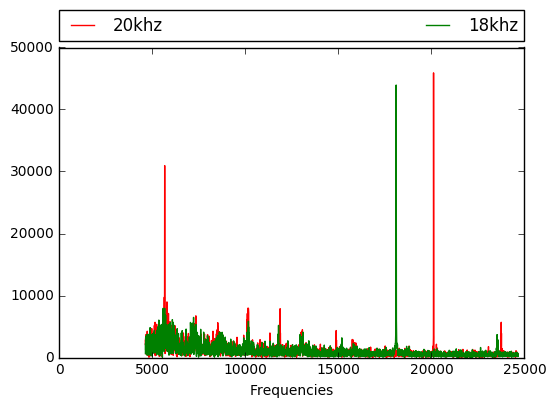

In [204]:
plt.plot(Freqs[750:4000], np.abs(FFT_20k[750:4000]),"r", label="20khz")
plt.plot(Freqs[750:4000], np.abs(FFT_18k[750:4000]),"g", label="18khz")
plt.xlabel("Frequencies")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.show()